Configuration & Path Setup

In [3]:
%load_ext autoreload
%autoreload 2

import warnings

# Ignore FutureWarnings from Scikit-Learn to clean up plot outputs
warnings.filterwarnings("ignore", category=FutureWarning)

### Identify the correct path on own computer

**goal** : not to have to change any path manually when running the code

In [4]:
import sys
from pathlib import Path

# 1. Define the Project Root
# Start at the current directory and look for 'src' to identify the root
current_dir = Path.cwd()
project_root = current_dir

while not (project_root / 'src').exists():
    if project_root == project_root.parent:
        # Hit the filesystem root without finding the project
        raise FileNotFoundError("Could not find project root containing 'src'")
    project_root = project_root.parent

# 2. Add Project Root to System Path
# This allows 'import src...' to work from anywhere
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# 3. Define Key Paths
DATA_PATH = project_root / "data"
MODELS_PATH = project_root / "models"

# 4. Verification
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")
print(f"Models Path:  {MODELS_PATH}")

Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data
Models Path:  /home/delaunan/code/delaunan/clintrialpredict/models


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules/Closses
from src.prep.data_loader import ClinicalTrialLoader
from src.prep.preprocessing import preprocessor

### Loading of source data project_data.csv
Delete the one already present in clintrialpredict/data/ if you want the latest version. <br>
if data_project.csv already exists in clintrialpredict/data/, the existing one will not be replaced by the latest one <br>
**goal** : not to have to rerun and build the source file every time.

In [6]:
import pandas as pd
# We don't even need 'import os' if we use pathlib correctly

# 1. Define path using the '/' operator (works because DATA_PATH is a Path object)
CSV_PATH = DATA_PATH / 'project_data.csv'
FORCE_REGENERATE = False

# 2. Check existence using .exists() method
if CSV_PATH.exists() and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")

    # Ensure ClinicalTrialLoader is imported from your src
    # from src.WP5_utils.data_loader import ClinicalTrialLoader

    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (69531, 67)


### Audit of features in data_project.csv (to be runned only to dig deeper)
Audit file with all information saved to clintrialpredict/data/audit_features.txt

In [7]:
from src.prep.audit_utils import run_master_audit

#Run the audit of features loaded into project_data.csv (will generate audit_full_report.txt in your data folder)

run_master_audit(DATA_PATH)

Reading /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv...
[1/9] Checking Dataset Health...
[2/9] Analyzing Categorical Risk Signals...
[3/9] Analyzing Numerical Impact...
[4/9] Generating Preprocessing Strategy...
[5/9] Calculating Correlations...
[6/9] Ranking Categorical Features...
[7/9] Checking Collinearity...
[8/9] Running Business Logic Checks...
[9/9] Writing Documentation...

Done. Audit saved to /home/delaunan/code/delaunan/clintrialpredict/data/audit_features.txt


### Train Test Split (default 80/20)

In [8]:
from src.models.train_test_split import temporal_train_test_split

# --- TRAIN TEST SPLIT ---
SPLIT_PERCENTAGE = 0.80

print(f"\nTesting Split with {SPLIT_PERCENTAGE*100}% Training Data...")


X_train, X_test, y_train, y_test = temporal_train_test_split(df, train_ratio=SPLIT_PERCENTAGE)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Testing Split with 80.0% Training Data...
X_train shape: (55624, 54)
y_train shape: (55624,)


In [9]:
import numpy as np

# 1. Count your zeros and ones
num_neg = np.sum(y_train == 0)
num_pos = np.sum(y_train == 1)

# 2. Calculate the ratio (Negatives / Positives)
# If you have fewer 1s, this number will be > 1, telling the model to pay more attention to them.
ratio = float(num_neg) / float(num_pos)

print(f"Count 0s (Negative): {num_neg}")
print(f"Count 1s (Positive): {num_pos}")
print(f"Calculated scale_pos_weight: {ratio:.4f}")

Count 0s (Negative): 47660
Count 1s (Positive): 7964
Calculated scale_pos_weight: 5.9844


### Model Training (model.fit)

In [ ]:
from sklearn.linear_model import LogisticRegression
from src.prep.preprocessing import preprocessor
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# --- 1. Define the Model ---
print("Initializing Logistic Regression...")
model = Pipeline([
    # The preprocessor will now include the new 'is_multi_phase' feature
    ('preprocessor', preprocessor()),
    ('classifier', XGBClassifier(
        # --- Core Parameters ---
        objective='binary:logistic',
        eval_metric='aucpr',

        # --- AGGRESSIVE REGULARIZATION (The settings that fixed the gap) ---
        n_estimators=300,            # Fixed low number
        learning_rate=0.02,          # Slow learning
        max_depth=3,                 # Shallow trees (CRITICAL)
        reg_lambda=15,               # Heavy L2 penalty
        gamma=1.0,                   # High minimum loss reduction
        min_child_weight=5,          # High minimum child weight

        # --- Standard Parameters ---
        subsample=0.8,
        colsample_bytree=0.8,

        # --- Imbalance Handling ---
        scale_pos_weight=ratio,

        # --- Technical Settings ---
        random_state=42,
        n_jobs=1,
        tree_method='hist'
    ))
])


# --- Fit the Model ---
print("Fitting XGBoost Model...")
model.fit(X_train, y_train)
print("✅ XGBoost Model Trained!")

Initializing Logistic Regression...
Fitting XGBoost Model...
✅ XGBoost Model Trained!



 PERFORMANCE AUDIT: Logistic Regression (Baseline)

[1] DISCRIMINATORY POWER (ROC-AUC): 0.7025
    - Industry Benchmark: 0.70 (Public Data) | 0.78+ (Proprietary Data)
    - Status: ⚠️ Acceptable

[2] FAILURE DETECTION CAPABILITY (PR-AUC): 0.2825
    - Baseline (Random Guess): 0.1607
    - Lift: 1.8x better than random guessing.

[3] PROBABILITY RELIABILITY (Brier Score): 0.2154
    - Goal: < 0.15 for high-confidence financial modeling.
--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT (With Interpretation):
                precision    recall  f1-score   support

 Completed (0)       0.91      0.62      0.74     11672   <-- Correctly approves 62% of safe trials
Terminated (1)       0.25      0.68      0.37      2235   <-- Catches 68% of failures (Precision: 25%)

      accuracy                           0.63     13907
     macro avg       0.58      0.65      0.55     13907
  weighted avg       0.80      0.63      0.68     1

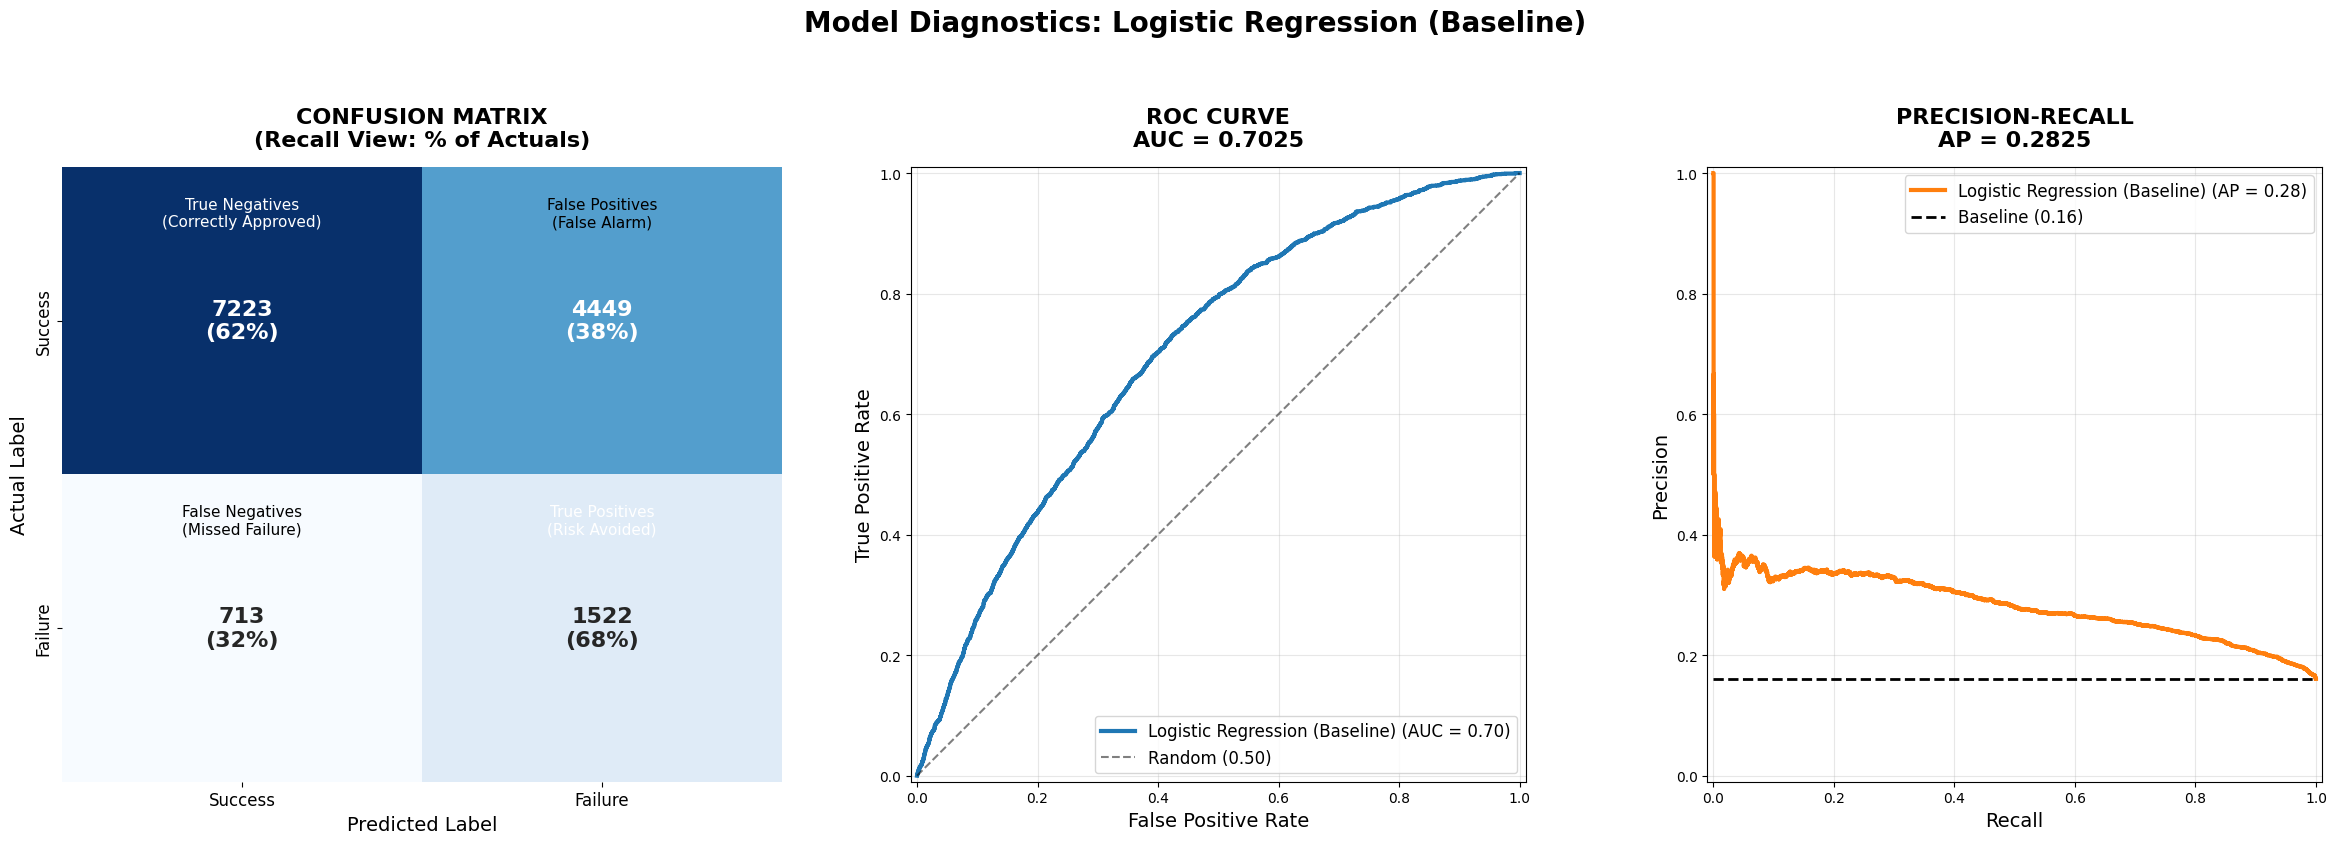


 DIAGNOSTIC: TEMPORAL LEARNING CURVE
Computing learning curve... (This may take a moment)

[RESULTS]
Final Training Score:   0.8341
Final Validation Score: 0.6749
Generalization Gap:     0.1592
>> DIAGNOSIS: High Overfitting. The model is memorizing historical noise.


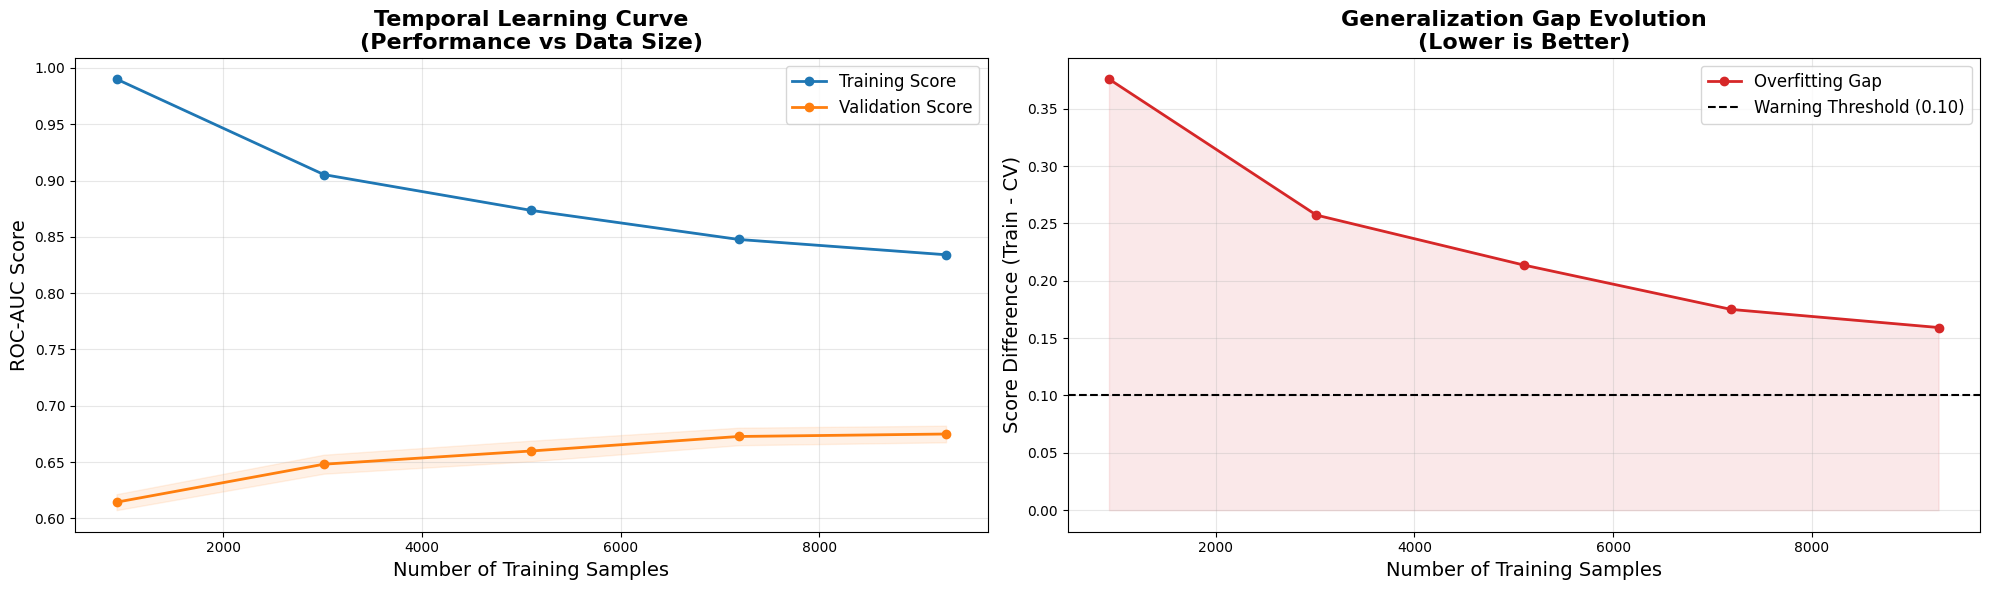


 💼 BUSINESS INTELLIGENCE: CROSS-SEGMENT ANALYSIS (FULL LIST)

[1] MAIN DIMENSIONS (Single Factors)
   Dimension       Segment  Count Fail_Rate ROC_AUC
       PHASE        PHASE1   4616     12.3%   0.765
       PHASE PHASE2/PHASE3    511     12.1%   0.699
       PHASE        PHASE3   2911     13.7%   0.651
       PHASE PHASE1/PHASE2   1234     24.7%   0.650
       PHASE        PHASE2   4635     19.4%   0.647
AGENCY_CLASS      INDUSTRY   7986     14.7%   0.720
AGENCY_CLASS       NETWORK     88     13.6%   0.696
AGENCY_CLASS         OTHER   5373     18.4%   0.686
AGENCY_CLASS     OTHER_GOV    107      9.3%   0.682
AGENCY_CLASS           NIH    278     13.3%   0.659
AGENCY_CLASS           FED     55     21.8%   0.636
AGENCY_CLASS         INDIV     16     12.5%   0.464

[2] CROSS-SEGMENTS (Agency + Phase Interaction) - ALL ROWS
                  Segment  Count Fail_Rate ROC_AUC
             FED / PHASE1     11      9.1%   1.000
         NETWORK / PHASE3     14     14.3%   0.917
      NIH /

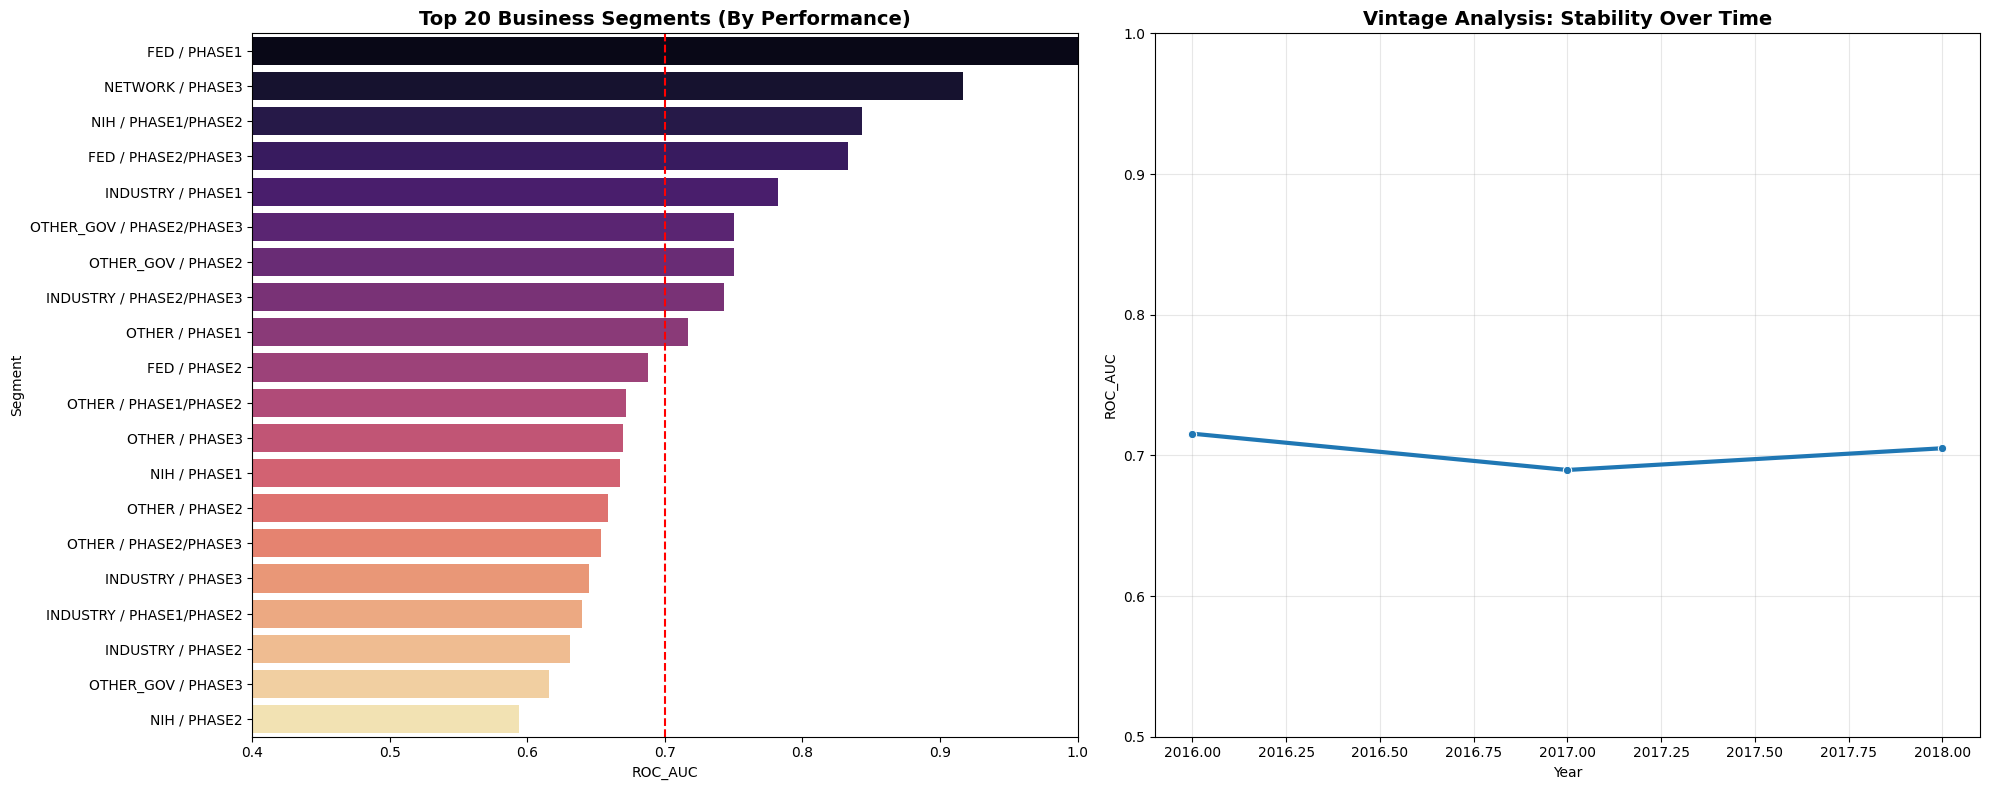

In [15]:
from src.models.evaluate import evaluate_model
# --- 2. RUN STANDARD EVALUATION ---
# This generates the Scorecard, Confusion Matrix, ROC, and PR Curves

metrics = evaluate_model(model, X_test, y_test, model_name="Logistic Regression (Baseline)")

from src.models.evaluate import plot_learning_curve

# --- 1. RUN TEMPORAL LEARNING CURVE ---
# This generates the Learning Curve to check for Overfitting/Underfitting
# cv=5 means it will test on 5 different time periods (expanding window)

plot_learning_curve(model, X_train, y_train, cv=5)

from src.models.evaluate_01 import evaluate_business_slices

# 1. Manually recreate the Test Split (Metadata + Features)
df_sorted = df.sort_values('start_date').reset_index(drop=True)
split_index = int(len(df_sorted) * 0.80)
df_test_full = df_sorted.iloc[split_index:].copy()

# ---------------------------------------------------------
# CRITICAL FIX: Generate Predictions First
# ---------------------------------------------------------
# We assume 'X_test' is the encoded feature set you used to validate the model.
# It must match the rows of df_test_full exactly.
df_test_full['y_prob'] = model.predict_proba(X_test)[:, 1]

# ---------------------------------------------------------
# 2. Run the Business Analysis
# ---------------------------------------------------------
# Correct Call: Pass ONLY the dataframe (now containing 'y_prob')
evaluate_business_slices(df_test_full)

### How to Read the Graphs (Cheat Sheet)

**1. Confusion Matrix (Operational Impact)**
*   **Bottom Left (False Negatives):** The "Capital Loss" quadrant. The model said "Safe", but the trial failed. Investors lose money here.
*   **Top Right (False Positives):** The "Opportunity Cost" quadrant. The model said "Risky", but the trial succeeded. Pharma misses a good drug here.

**2. ROC Curve (Global Separability)**
*   **What it tells us:** How good is the model generally?
*   **The Line:** The more it hugs the top-left corner, the better.
*   **The Diagonal:** If the line is on the diagonal, the model is guessing (useless).

**3. Precision-Recall Curve (The Imbalance Truth)**
*   **What it tells us:** Can we trust the "Risk" flags?
*   **Context:** Since failures are rare (15%), this is the most honest view.
*   **The Baseline:** The dashed line represents the failure rate (0.15). We want our curve to be significantly higher than this line.

**4. Temporal Learning Curve (Stability)**
*   **Blue Line:** How well the model knows history.
*   **Orange Line:** How well the model predicts the future.
*   **Convergence:** We want the Orange line to go UP and get closer to the Blue line as we add more data. If the Orange line stays flat, adding more data won't help (we need better features).

### Save model (not to have to re-run model.fit next time so that you start with the correct weights)
prerequisite will be Train_test_split to recuperate the X_train, y_train, X_test, y_test to feed into pretrained model.

In [18]:
import joblib

# 1. Define the filename in a variable
MODEL_FILENAME = 'logreg_baseline.joblib'

# 2. Construct the full path using the pathlib object
# This ensures it goes to 'CLINTRIALPREDICT/models/', not 'src/models/'
save_path = MODELS_PATH / MODEL_FILENAME

# 3. Save the model
print(f"Saving model to: {save_path} ...")
joblib.dump(model, save_path)

print(f"✅ Model successfully saved as '{MODEL_FILENAME}' in the project root models folder.")

Saving model to: /home/delaunan/code/delaunan/clintrialpredict/models/logreg_baseline.joblib ...
✅ Model successfully saved as 'logreg_baseline.joblib' in the project root models folder.


### Imprort pre-trained model (not to have to re-run model.fit)
prerequisite Train_test_split to recuperate the X_train, y_train, X_test, y_test to feed into pretrained model.

In [ ]:
# Import the loader
from src.models.model_utils import load_model

# Retrieve the model from the file
my_loaded_model = load_model('logreg_baseline.joblib')

# Verify it works by making a prediction on the first 5 rows of test data
print("\nTesting loaded model...")
sample_probs = my_loaded_model.predict_proba(X_test.head(5))[:, 1]
print(f"Predictions for first 5 trials: {sample_probs}")

>>> Loading model from: /home/delaunan/code/delaunan/clintrialpredict/src/models/logreg_model.joblib

Testing loaded model...
Predictions for first 5 trials: [0.40835685 0.31814536 0.59581191 0.11837591 0.33292536]
